## Reinforcement Learning

In [27]:
import numpy as np
import matplotlib.pyplot as plt

import matplotlib
matplotlib.rcParams['figure.dpi']=300 # highres display

# for subplots within subplots:
from matplotlib import gridspec

#For silly animations
from IPython.display import clear_output
from time import sleep

In [34]:
# Maze generation algorithm from wikipedia
# the code was removed in January 2020, but you can still
# access it under this link:
# https://en.wikipedia.org/w/index.php?title=Maze_generation_algorithm&oldid=930153705


def generate_maze(width=81, height=51, complexity=.75, density=.75):
    """Generate a maze using a maze generation algorithm."""
    # Only odd shapes
    shape = ((height // 2) * 2 + 1, (width // 2) * 2 + 1)
    # Adjust complexity and density relative to maze size
    complexity = int(complexity * (5 * (shape[0] + shape[1])))  # Number of components
    density    = int(density * ((shape[0] // 2) * (shape[1] // 2)))  # Size of components
    # Build actual maze
    Z = np.zeros(shape, dtype=bool)
    # Fill borders
    Z[0, :] = Z[-1, :] = 1
    Z[:, 0] = Z[:, -1] = 1
    # Make aisles
    for i in range(density):
        x, y = np.random.randint(0, shape[1] // 2) * 2, np.random.randint(0, shape[0] // 2) * 2  # Pick a random position
        Z[y,x] = 1
        for j in range(complexity):
            neighbours = []
            if x > 1:             neighbours.append((y, x - 2))
            if x < shape[1] - 2:  neighbours.append((y, x + 2))
            if y > 1:             neighbours.append((y - 2, x))
            if y < shape[0] - 2:  neighbours.append((y + 2, x))
            if len(neighbours):
                y_, x_ = neighbours[np.random.randint(0, len(neighbours) - 1)]
                if Z[y_, x_] == 0:
                    Z[y_, x_] = 1
                    Z[y_ + (y - y_) // 2, x_ + (x - x_) // 2] = 1
                    x, y = x_, y_
    return Z
generate_maze(6,6)

array([[ True,  True,  True,  True,  True,  True,  True],
       [ True, False, False, False, False, False,  True],
       [ True, False,  True,  True,  True, False,  True],
       [ True, False, False, False, False, False,  True],
       [ True, False, False, False, False, False,  True],
       [ True, False, False, False, False, False,  True],
       [ True,  True,  True,  True,  True,  True,  True]])

[]

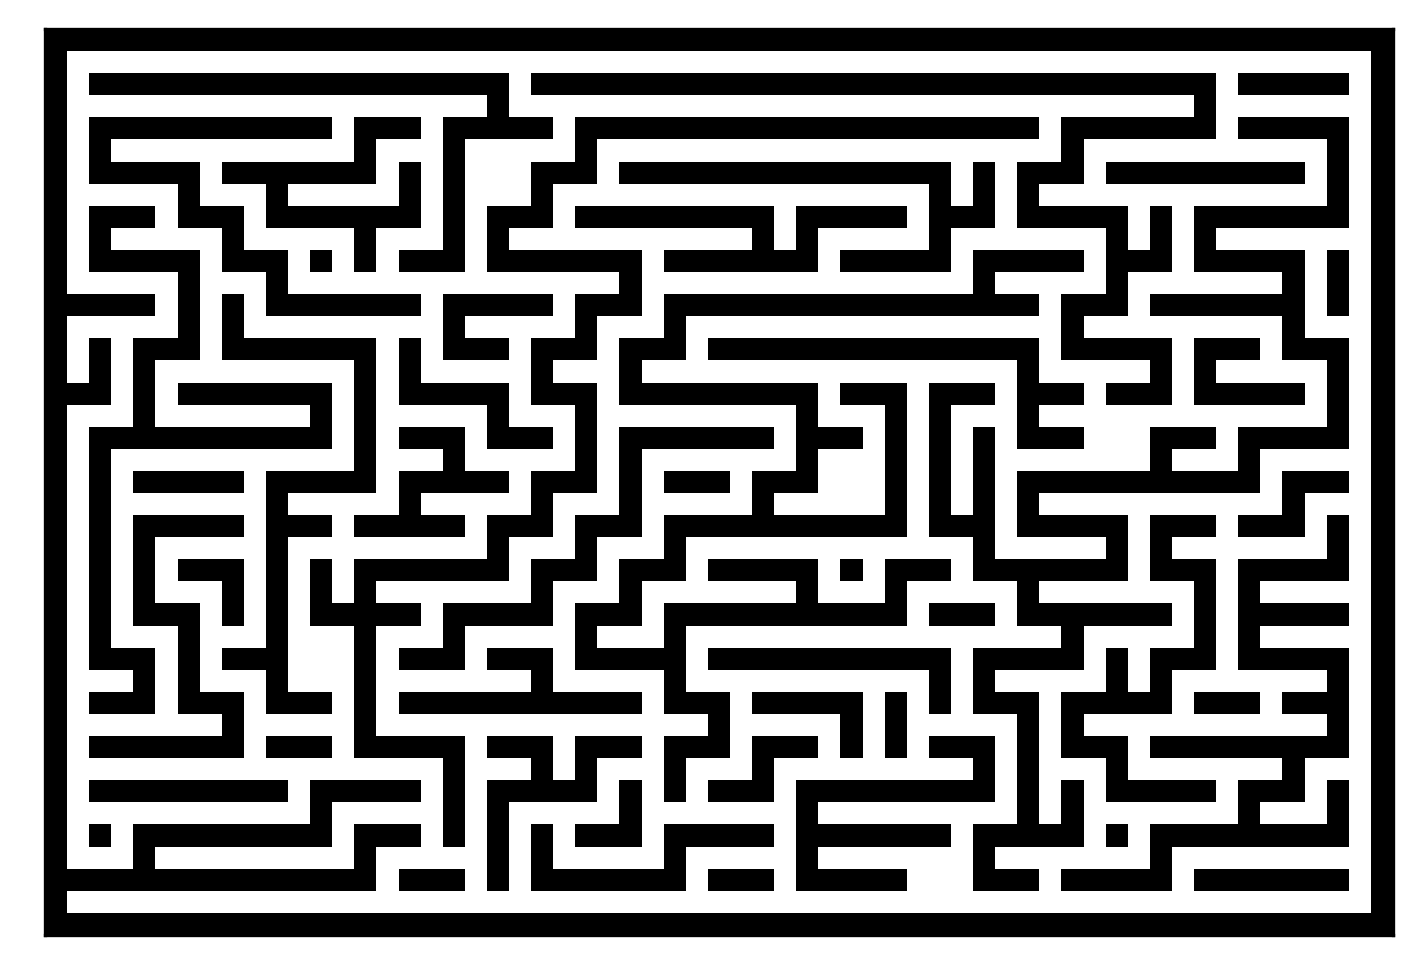

In [24]:
fix,ax=plt.subplots()
ax.imshow(generate_maze(60, 40), cmap=plt.cm.binary, interpolation='nearest')
ax.set_xticks([]) 
ax.set_yticks([])

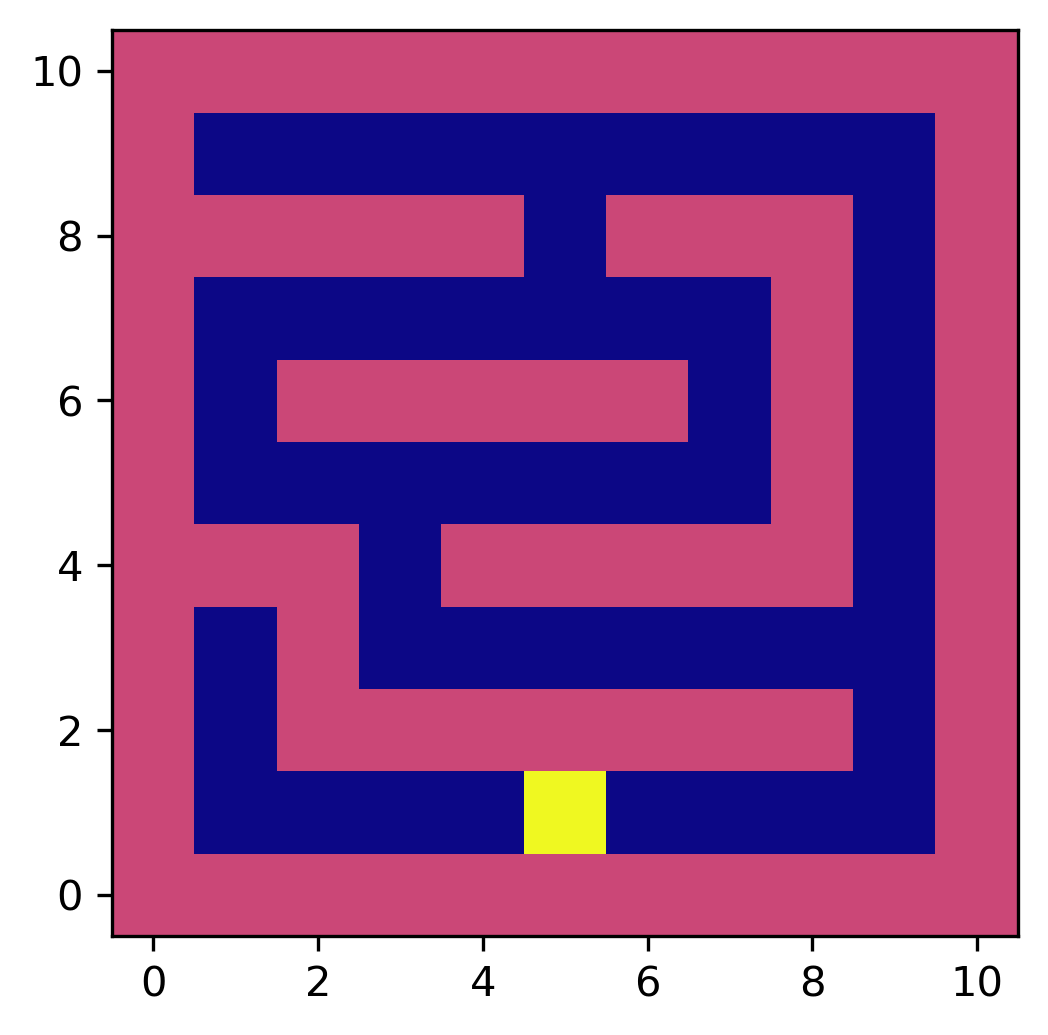

In [33]:
# make a maze, convert array from True/False to integer:
world=np.array(generate_maze(width=11,height=11),dtype='int')

# the four directions of motion [delta_jx,delta_jy]:
directions=np.array([[0,1],[0,-1],[1,0],[-1,0]])

# initial position
jx,jy=1,1

# take a random walk through the maze and animate this!
nsteps=40
for j in range(nsteps):
    # make a random step
    pick=np.random.randint(4)
    jx_new,jy_new=np.array([jx,jy])+directions[pick]
    if world[jx_new,jy_new]==0: # is empty, can move!
        jx,jy=jx_new,jy_new
        # show what's happening
        picture=np.copy(world) # copy the array (!)
        picture[jx,jy]=2
        plt.imshow(picture,origin='lower',cmap=plt.cm.plasma )
        plt.show()
        sleep(0.01)
        clear_output(wait=True)

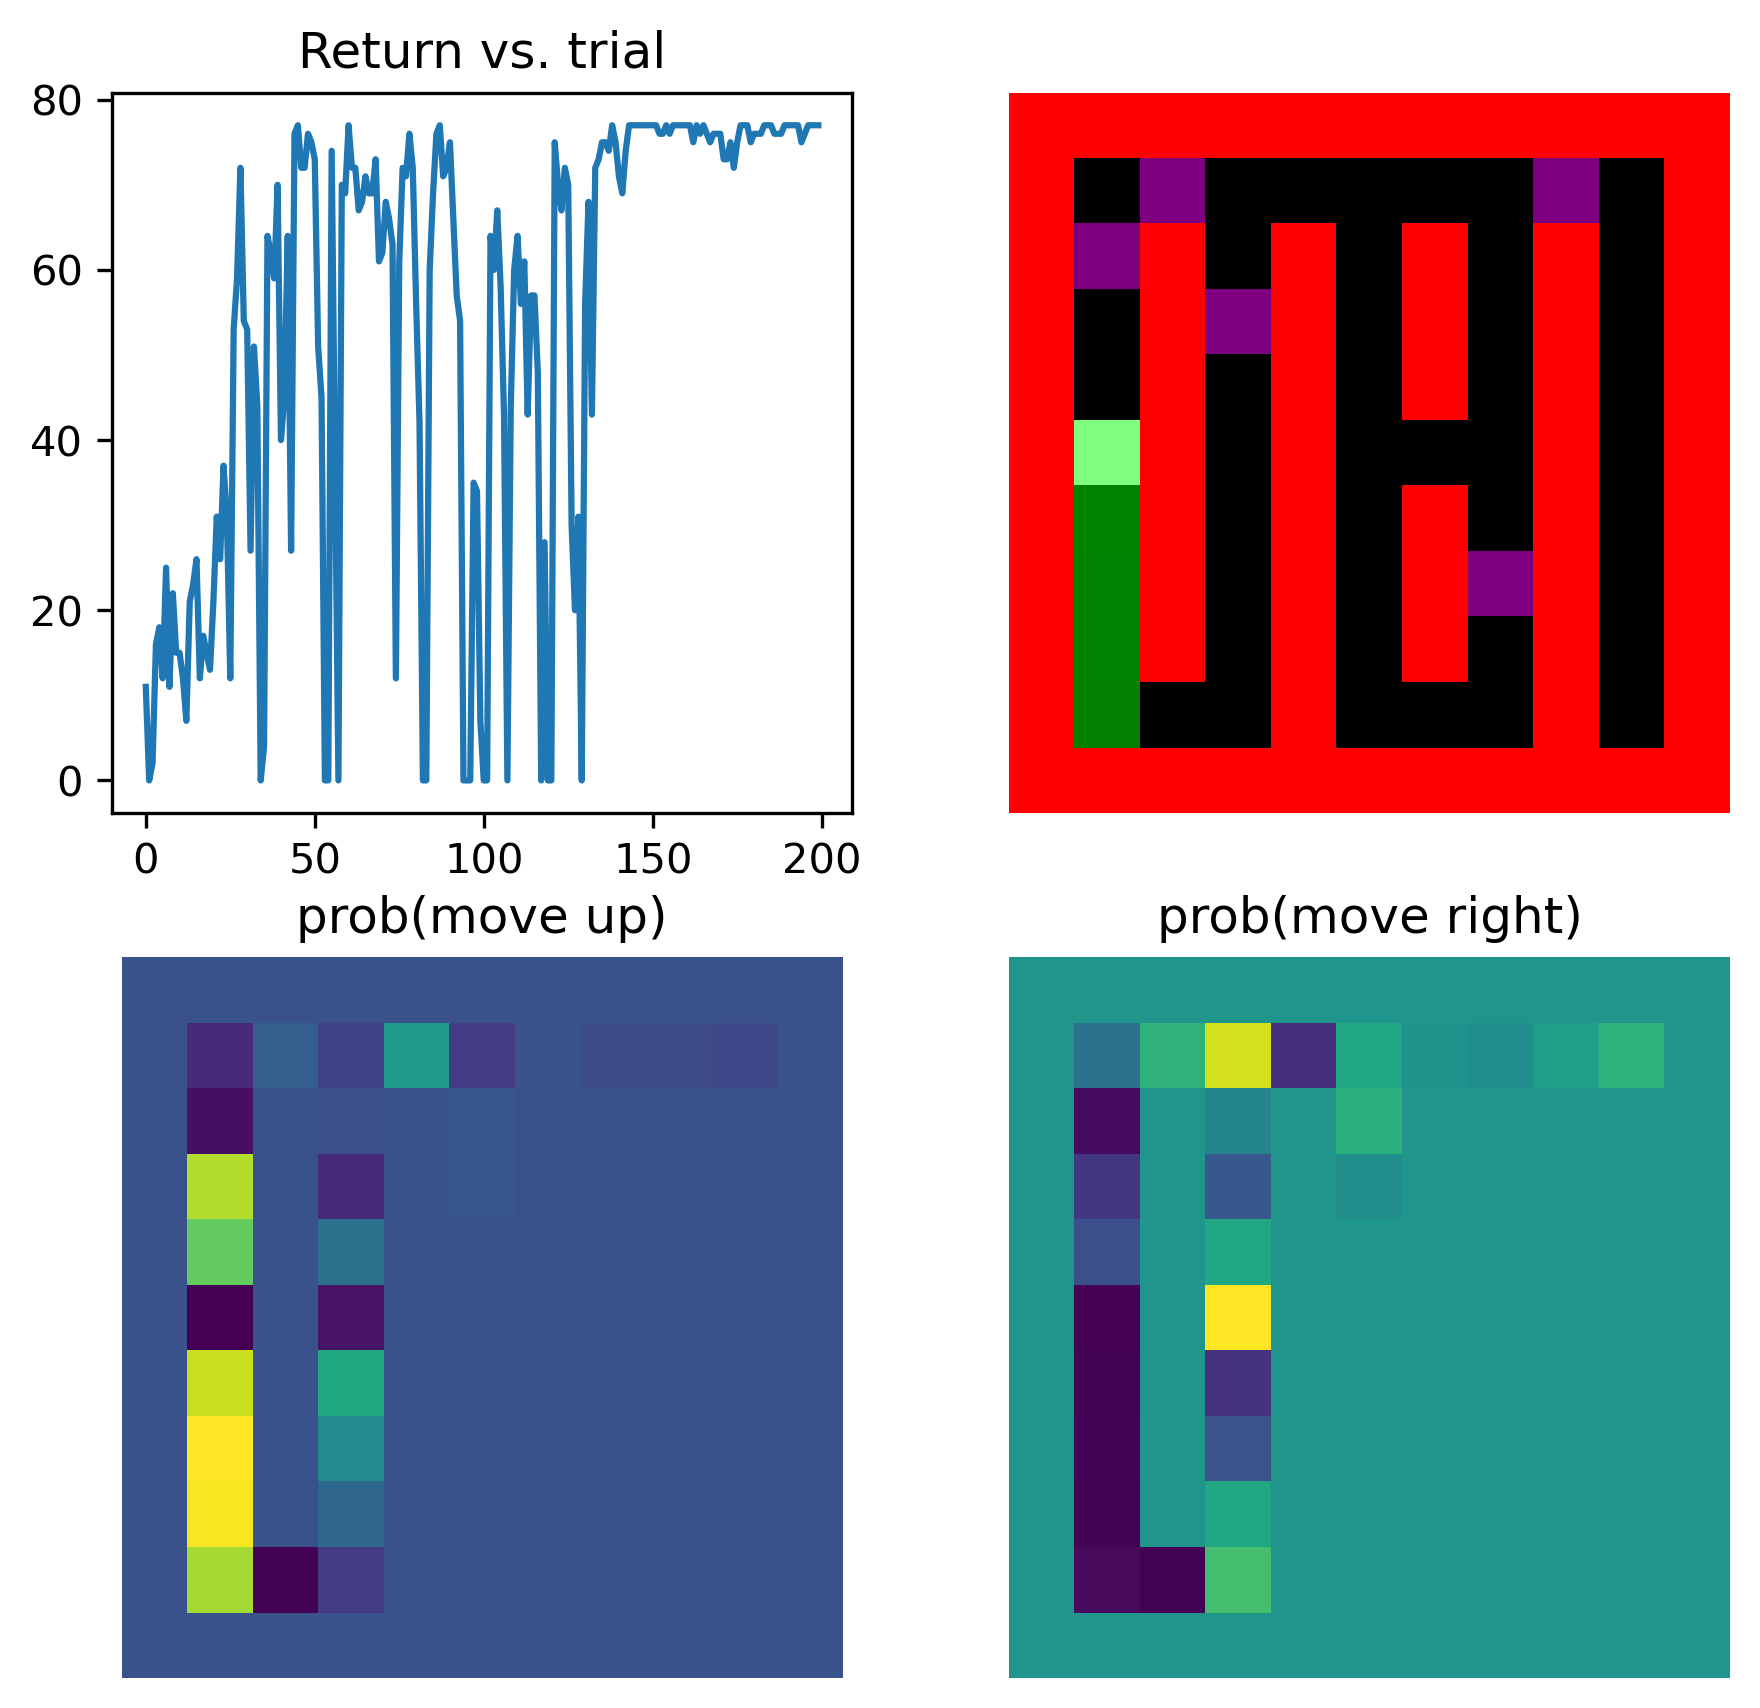

In [41]:
# full policy gradient RL for picking up 'treasure chests'
# in an automatically generated maze; 2020 by F.M.

M=11 # the size of the world: M x M
eta=0.01 # the learning rate
num_chests=10 # maximum number of treasure chests

# make a maze, convert array from True/False to integer:
world=np.array(generate_maze(width=M,height=M),dtype='int')

# the four directions of motion [delta_jx,delta_jy]:
directions=np.array([[0,1],[0,-1],[1,0],[-1,0]])

# the policy probabilities as an array policy[state,action]
# here the state is represented by two coordinates jx,jy
policy=np.full([M,M,4],0.25)
# and also the underlying 'z'-values for the
# softmax parametrization:
policy_z=np.full([M,M,4],0.0)

# steps inside one trajectory
nsteps=80

# total number of trials, i.e. trajectories
ntrials=200
skipsteps=5 # don't plot every trial

# storing all the state/action pairs of the current trajectory
states=np.zeros([nsteps,2], dtype='int')
actions=np.zeros(nsteps, dtype='int')

# a map of rewards (the 'boxes' are here!)
reward=np.zeros([M,M])

# storing all the returns, for all trials:
Returns=np.zeros(ntrials)

# try random selection of reward sites (treasure chests)
for n in range(10): 
    jx_target,jy_target=np.random.randint(M,size=2)
    if jx_target>4 or jy_target>4: # stay away from starting point!
        if world[jx_target,jy_target]==0: # empty, keep it!
            reward[jx_target,jy_target]+=1
        
# try many trajectories:
for trial in range(ntrials):

    # set return to zero for this trajectory:
    R=0
    # initial position:
    jx,jy=1,1
    
    # go through all time steps
    for t in range(nsteps):
        # make a random step, according to the policy distribution
        p=np.random.uniform()
        cumulative_distribution=np.cumsum(policy[jx,jy,:])
        for pick in range(4):
            if p<cumulative_distribution[pick]:
                break

        # record the move
        states[t,0]=jx
        states[t,1]=jy
        actions[t]=pick

        # now make the move
        jx_new,jy_new=np.array([jx,jy])+directions[pick]

        # really make it if there is no wall:
        if world[jx_new,jy_new]==0: # is empty, can move!
            jx,jy=jx_new,jy_new
        
        # get a reward if on a treasure chest!
        r=reward[jx,jy]
        R+=r
   
    # store the return
    Returns[trial]=R
    
    # use policy gradient update rule to adjust
    # probabilities!
    for t in range(nsteps): # go through the trajectory again
        a=actions[t] # remember the action taken at step t
        sx=states[t,0] # state/x-position at step
        sy=states[t,1] # state/y-position
        kronecker=np.zeros(4); kronecker[a]=1.0
        policy_z[sx,sy,:]+=eta*R*(kronecker-policy[sx,sy,:])

    # now calculate (again) the policy probab. from the z-values
    policy=np.exp(policy_z)
    policy/=np.sum(policy,axis=2)[:,:,None] # normalize
    # these two steps together implement softmax on every
    # site! efficient array syntax!
    
    # visualize!
    if trial%skipsteps==0 or trial==ntrials-1:
        # show what's happened in this trajectory
        clear_output(wait=True)
        fig,ax=plt.subplots(ncols=2,nrows=2,figsize=(7,7))
        ax[0,0].plot(Returns) # all the returns, in all trials
        ax[0,0].set_title("Return vs. trial")
        
        picture=np.zeros([M,M,3]) # last index: red/green/blue
        picture[:,:,0]=world # walls are red
        for j in range(nsteps): # highlight trajectory
            picture[states[j,0],states[j,1],1]=0.5*(1.0+(1.0*j)/nsteps)
        # put a bright pixel at the positions visited
        picture[:,:,2]+=0.5*reward # highlight the target sites!
        picture[:,:,0]+=0.5*reward

        # show picture (transpose is needed because
        # otherwise the first coordinate jx is plotted upwards,
        # not to the right)
        ax[0,1].imshow(np.transpose(picture,[1,0,2]),origin='lower')
        ax[0,1].axis('off')
        
        ax[1,0].imshow(np.transpose(policy[:,:,0]),origin='lower')
        ax[1,0].axis('off')
        ax[1,0].set_title("prob(move up)")
        ax[1,1].imshow(np.transpose(policy[:,:,2]),origin='lower')
        ax[1,1].set_title("prob(move right)")
        ax[1,1].axis('off')
        plt.show()